# IBM Capstone Project - Where shall I expand my fruit shop to: Toronto or London?
## Introduction - The Business Problem

One of our clients has multiple success fruit shops within New York and is seeking to expand their business Internationally.  The client would like to either expand their business to Toronto or London, and open multiple shops in the new city.  

The client knows that the neighbourhoods their shops are located in in New York are the most likely to return high profits.  The client would like to know whether to Toronto or London has more neighbourhoods which are similar to the neighbourhoods their shops are located in in New York.  This will inform their decision on where to open the shops. 


**The aim of this project is therefore to identify whether London or Toronto have more neighbourhoods which are similar to the neighbourhoods that the clients shops are currently located in in New York.**

## Planned Data Usage

In order to conduct this analysis, I will need access neighbourhood datasets for New York, Toronto and London.  I will also need acces to the longitude and latitude for each of these neighbourhoods.  This will be obtained using the following websites: 
1. **New York**
    + Post Codes: https://cocl.us/new_york_dataset
    + Locations: https://cocl.us/new_york_dataset
2. **Toronto**
    + Post Codes: https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.
    + Locations: http://cocl.us/Geospatial_data
3.  **London**
    + Post Codes: https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom (multiple links from this) 
    + Locations: https://www.freemaptools.com/download-uk-postcode-lat-lng.htm (will average accross each postcode within a region)

I will also need access to data which in some way helps to categorise the types of neighbourhoods.  This will be achieved by using https://foursquare.com/ to identify the most common venue types within each neighbourhood. 

I would have liked to conduct analysis on the types of people that live in each neighbourhood (e.g. shopping habits - Amazon, viewing habits - Netflix), but this type of data is not freely available.  

In reality, there are multiple other factors that would need to be taken into account before making this decision, such as availablity of stock and costs.  However, in this report I will only focus on identifying which city would be best based on the number of similar neighbourhoods. 

## Methodology

+ **Step 1** - Import all of the libraries required for this notebook
+ **Step 2** - Create a Dataframe containing the Neighbourhoods and their locations for New York
+ **Step 3** - Create a Dataframe containing the Neighbourhoods and their locations for Toronto
+ **Step 4** - Create a Dataframe containing the Neighbourhoods and their locations for London
+ **Step 5** - Inital Analysis conducted on New York, Toronto and London neighbourhoods
+ **Step 6** - Create a map of New York, Toronto and London showing all of their neighbourhoods, and display the boroughs in different colours.
+ **Step 7** - Define a function to query Foursquare for each city and set up Foursquare credentials
+ **Step 8** - Get Venues close to each neighbourhood in New York and put the results into a dataframe
+ **Step 9** - Get Venues close to each neighbourhood in Toronto and put the results into a dataframe
+ **Step 10** - Get Venues close to each neighbourhood in London and put the results into a dataframe
+ **Step 11** - Conduct initial Analysis on venues returned for New York, Toronto and London
+ **Step 12** - Prepare the data for k-means clustering
+ **Step 13** - Identify the optimum K value for K means clustering
+ **Step 14** - Conduct K means clustering with k = 4
+ **Step 15** - Create a map of New York, Toronto and London showing all the cluster associated with each neighbourhood in different colours

### Step 1 - Import all libraries required for this notebook

In [297]:
import pandas as pd
import numpy as np
import json

# Folium and geo features needed
import folium
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests

from sklearn.cluster import KMeans

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


### Step 2 - Create a Dataframe containing the Neighbourhoods and their locations for New York 

In [24]:
# Load the json file into variable called ny_1
with open('nyu_2451_34572-geojson.json') as json_data:
    ny_1 = json.load(json_data)

# Only pull back features, and store in variable called ny_2
ny_2 = ny_1['features']

# Create an empty datafram2 with columns for Boroguh, Neighbourhood, Lattitue and Longitude
ny_df = pd.DataFrame(columns = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] )

# Load the data from ny_2 into the dataframe
for data in  ny_2:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_df = ny_df.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Add a coloumn to categorise the Boroughs which is required for plotting the boroughs in differnt colours
ny_df["Borough_Cats"] = ny_df['Borough'].astype('category').cat.codes

# Show a sample of the data
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude,Borough_Cats
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0


### Step 3 - Create a Dataframe containing the Neighbourhoods and their locations for Toronto

In [77]:
# Load the neighbourhood data for Toronto into a list 
tn_list = pd.read_html("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.")

# Create a datafram for toronto data, this only contains PostalCode Borough and Neighbourhood
tn_neigh_df = tn_list[0]
tn_neigh_df.rename(columns = {'Postcode':'PostalCode'}, inplace = True)

# Ignore cells with a borough that is 'Not assigned'
tn_neigh_df = tn_neigh_df[tn_neigh_df.Borough != 'Not assigned'].reset_index(drop = True)

# Wrap up all neighbourhoods for each Borough (achieved by calling old version of wiki page)
tn_neigh_df = tn_neigh_df.groupby(["PostalCode", "Borough"]).agg({'Neighbourhood' : lambda x: ', '.join(x)}).reset_index()
tn_neigh_df.drop(["Neighbourhood"], axis = 1, inplace = True)

# Read the geospatial data for Toronto into a dataframe
tn_geo_df = pd.read_csv("http://cocl.us/Geospatial_data")
tn_geo_df.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)

# Merge the geospatial data and the Borough/Neighborhood data
tn_df = pd.merge(tn_neigh_df, tn_geo_df, on = "PostalCode", how = "inner")
tn_df.rename(columns = {"PostalCode": "Neighbourhood"}, inplace = True)

# Add a coloumn to categorise the Boroughs which is required for plotting the boroughs in differnt colours
tn_df["Borough_Cats"] = tn_df['Borough'].astype('category').cat.codes

tn_df.head()

,Neighbourhood,Borough,Latitude,Longitude,Borough_Cats
0,M1B,Scarborough,43.806686,-79.194353,7
1,M1C,Scarborough,43.784535,-79.160497,7
2,M1E,Scarborough,43.763573,-79.188711,7
3,M1G,Scarborough,43.770992,-79.216917,7
4,M1H,Scarborough,43.773136,-79.239476,7


### Step 4 - Create a Dataframe containing the Neighbourhoods and their locations for London

In [565]:
# For each of the borough: download the data, extract it, add a column to label the Borough and drop any irrelevant columns 
# North London
n_london_list = pd.read_html("https://en.wikipedia.org/wiki/N_postcode_area")
n_london_df = n_london_list[1]
n_london_df["Borough"] = "North London"
n_london_df = n_london_df[["Postcode district", "Borough"]]

# North West London
nw_london_list = pd.read_html("https://en.wikipedia.org/wiki/NW_postcode_area")
nw_london_df = nw_london_list[1]
nw_london_df["Borough"] = "North West London"
nw_london_df = nw_london_df[["Postcode district", "Borough"]]

# West London
w_london_list = pd.read_html("https://en.wikipedia.org/wiki/W_postcode_area")
w_london_df = w_london_list[1]
w_london_df["Borough"] = "West London"
w_london_df = w_london_df[["Postcode district", "Borough"]]

# Western Central London
wc_london_list = pd.read_html("https://en.wikipedia.org/wiki/WC_postcode_area")
wc_london_df = wc_london_list[1]
wc_london_df["Borough"] = "Western Central London"
wc_london_df = wc_london_df[["Postcode district", "Borough"]]

# East Central London
ec_london_list = pd.read_html("https://en.wikipedia.org/wiki/EC_postcode_area")
ec_london_df = ec_london_list[1]
ec_london_df["Borough"] = "East Central London"
ec_london_df = ec_london_df[["Postcode district", "Borough"]]
    
# East London
e_london_list = pd.read_html("https://en.wikipedia.org/wiki/E_postcode_area")
e_london_df = e_london_list[1]
e_london_df["Borough"] = "East London"
e_london_df = e_london_df[["Postcode district", "Borough"]]

# South East London
se_london_list = pd.read_html("https://en.wikipedia.org/wiki/SE_postcode_area")
se_london_df = se_london_list[1]
se_london_df["Borough"] = "South East London"
se_london_df = se_london_df[["Postcode district", "Borough"]]

# South West London
sw_london_list = pd.read_html("https://en.wikipedia.org/wiki/SW_postcode_area")
sw_london_df = sw_london_list[1]
sw_london_df["Borough"] = "South West London"
sw_london_df = sw_london_df[["Postcode district", "Borough"]]

sw_london_df.head()

ln_neigh_df = pd.concat([n_london_df, nw_london_df, w_london_df, wc_london_df, ec_london_df, e_london_df, 
                        se_london_df, sw_london_df], ignore_index=True, sort =False)

ln_neigh_df.rename(columns = {"Postcode district": "Neighbourhood"}, inplace = True)

In [185]:
# Import the geo data for UK postcodes
ln_geo_df = pd.read_csv("ukpostcodes.csv")

# Split the postcode to obtain the neighbourhood
ln_geo_df["Neighbourhood"] = ln_geo_df["postcode"].str.split(expand = True)[0]

# Find the mean longitude and latitude within each of the postcodes, as a very crude centre.
ln_geo_df = ln_geo_df[["Neighbourhood", "latitude", "longitude"]].groupby(["Neighbourhood"]).mean().reset_index()

# Join the neighbourhood dataset and locations dataset for the finished result
ln_df = pd.merge(ln_neigh_df, ln_geo_df, on = "Neighbourhood", how = "inner")

# Add a coloumn to categorise the Boroughs which is required for plotting the boroughs in differnt colours
ln_df["Borough_Cats"] = ln_df['Borough'].astype('category').cat.codes

ln_df.head()

,Neighbourhood,Borough,latitude,longitude,Borough_Cats
0,N1,North London,51.537726,-0.097068,2
1,N1C,North London,51.536516,-0.125844,2
2,N1P,North London,55.665844,-0.094719,2
3,N2,North London,51.590088,-0.169277,2
4,N3,North London,51.600244,-0.193908,2


### Step 5 - Conduct some inital analysis against boroughs and neighbourhoods in each of the three cities

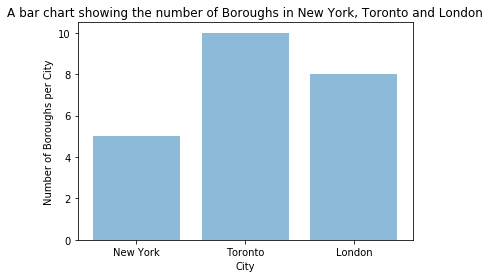

In [91]:
# How many Boroughs in each city?
y_labels = ("New York", "Toronto", "London")
y_label_positions = np.arange(len(y_labels))
x_values = [ny_df["Borough_Cats"].nunique(), tn_df["Borough_Cats"].nunique(), ln_df["Borough_Cats"].nunique()]

plt.bar(y_labels, x_values, align = "center", alpha = 0.5)
plt.xlabel("City")
plt.ylabel("Total number of Boroughs per City")
plt.title("A bar chart showing the number of Boroughs in New York, Toronto and London")

plt.show()

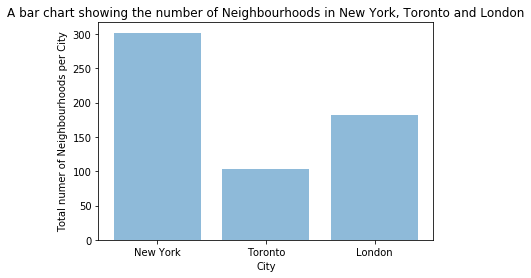

In [94]:
# How many Neighbourhoods within each city? 
y_labels = ("New York", "Toronto", "London")
y_label_positions = np.arange(len(y_labels))
x_values = [ny_df["Neighbourhood"].nunique(), tn_df["Neighbourhood"].nunique(), ln_df["Neighbourhood"].nunique()]

plt.bar(y_labels, x_values, align = "center", alpha = 0.5)
plt.xlabel("City")
plt.ylabel("Total number of Neighbourhoods per City")
plt.title("A bar chart showing the number of Neighbourhoods in New York, Toronto and London")

plt.show()

Text(0, 0.5, 'Spread of the number of neighbourhoods per borough')

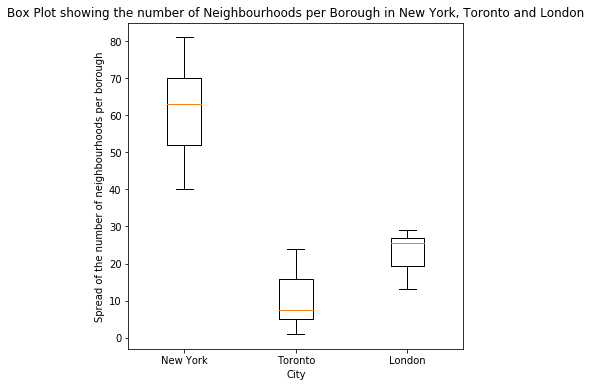

In [149]:
# How may Boroughs per Neighbourhood in each city? 
ny_bp_tmp = ny_df[["Borough", "Neighbourhood"]].groupby("Borough").count()
ny_bp_tmp.reset_index(inplace = True)

tn_bp_tmp = tn_df[["Borough", "Neighbourhood"]].groupby("Borough").count()
tn_bp_tmp.reset_index(inplace = True)

ln_bp_tmp = ln_df[["Borough", "Neighbourhood"]].groupby("Borough").count()
ln_bp_tmp.reset_index(inplace = True)

data_to_plot = [list(ny_bp_tmp["Neighbourhood"]), list(tn_bp_tmp["Neighbourhood"]), list(ln_bp_tmp["Neighbourhood"])]

# Create a figure instance
fig = plt.figure(1, figsize=(6, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['New York', 'Toronto', 'London'])
ax.set_title("Box Plot showing the number of Neighbourhoods per Borough in New York, Toronto and London")
ax.set_xlabel("City")
ax.set_ylabel("Spread of the number of neighbourhoods per borough")

### Step 6 - Create a map for New York, Toronto and London showing the neighbourhoods

In [561]:
# NEW YORK
# Create an instance of the geolocator to obtain coordinates for New York
ny_geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode("New York City")

# Create a instance of the folium map, centred around the coordinates for New York
ny_map = folium.Map(location=[ny_location.latitude, ny_location.longitude], zoom_start=10)

# Creat an array of colors required for plotting each of the boroughs in different colours on the map
ny_x = ny_df["Borough_Cats"].unique()
ny_y = [i + ny_x + (i*ny_x)**2 for i in range(ny_df["Borough_Cats"].nunique())]
ny_colors_array = cm.rainbow(np.linspace(0, 1, len(ny_y)))
ny_rainbow = [colors.rgb2hex(i) for i in ny_colors_array]

# Add the neighbourhoods onto the map of New York
for lat, lng, neigh, borough in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Neighbourhood'], ny_df["Borough_Cats"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=ny_rainbow[borough-1],
        fill=True,
        fill_color=ny_rainbow[borough-1],
        fill_opacity=0.7).add_to(ny_map)  

ny_map

In [562]:
# TORONTO
# Create an instance of the geolocator to obtain coordinates for Toronto
tn_geolocator = Nominatim(user_agent="tn_explorer")
tn_location = geolocator.geocode("Toronto")

# Create a instance of the folium map, centred around the coordinates for Toronto
tn_map = folium.Map(location=[tn_location.latitude, tn_location.longitude], zoom_start=10)

# Create an array of colors required for plotting each of the boroughs in different colours on the map
tn_x = tn_df["Borough_Cats"].unique()
tn_y = [i + tn_x + (i*tn_x)**2 for i in range(tn_df["Borough_Cats"].nunique())]
tn_colors_array = cm.rainbow(np.linspace(0, 1, len(tn_y)))
tn_rainbow = [colors.rgb2hex(i) for i in tn_colors_array]

# Add the neighbourhoods onto the map of Toronto
for lat, lng, neigh, borough in zip(tn_df['Latitude'], tn_df['Longitude'], tn_df['Neighbourhood'], tn_df["Borough_Cats"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=tn_rainbow[borough-1],
        fill=True,
        fill_color=tn_rainbow[borough-1],
        fill_opacity=0.7).add_to(tn_map)  

tn_map

In [563]:
# LONDON
# Create an instance of the geolocator to obtain coordinates for London
ln_geolocator = Nominatim(user_agent="ln_explorer")
ln_location = geolocator.geocode("London")

# Create a instance of the folium map, centred around the coordinates for London
ln_map = folium.Map(location=[ln_location.latitude, ln_location.longitude], zoom_start=10)

# Create an array of colors required for plotting each of the boroughs in different colours on the map
ln_x = ln_df["Borough_Cats"].unique()
ln_y = [i + ln_x + (i*ln_x)**2 for i in range(ln_df["Borough_Cats"].nunique())]
ln_colors_array = cm.rainbow(np.linspace(0, 1, len(ln_y)))
ln_rainbow = [colors.rgb2hex(i) for i in ln_colors_array]

# Add the neighbourhoods onto the map of London
for lat, lng, neigh, borough in zip(ln_df['latitude'], ln_df['longitude'], ln_df['Neighbourhood'], ln_df["Borough_Cats"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=ln_rainbow[borough-1],
        fill=True,
        fill_color=ln_rainbow[borough-1],
        fill_opacity=0.7).add_to(ln_map)  

ln_map

### Step 7 - Define a function to query Foursquare for each city and set up Foursquare credentials

In [338]:
# Define the function to get the nearby venues
def getNearbyVenues(boroughs, names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [564]:
# Set up credentials for Foursquare
CLIENT_ID = 'REDACTED' # your Foursquare ID
CLIENT_SECRET = 'REDACTED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Step 8 - Get Venues close to each neighbourhood in New York and put the results into a dataframe

In [362]:
# Comment out to avoid accidently running
# ny_venues_df = getNearbyVenues(boroughs = ny_df["Borough"],
#                                 names=ny_df['Neighbourhood'],
#                                 latitudes=ny_df['Latitude'],
#                                 longitudes=ny_df['Longitude']
#                                   )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [363]:
# Save the Data to CSV to prevent having to rerun agaisnt Foursquare (due to limitations on number of queries per day)
ny_venues_df.to_csv ("newyork_1.csv", index = False, header=True)

### Step 9 - Get Venues close to each neighbourhood in Toronto and put the results into a dataframe

In [342]:
# Comment out to avoid accidently running
# tn_venues_df = getNearbyVenues(boroughs = tn_df["Borough"],
#                                 names=tn_df['Neighbourhood'],
#                                 latitudes=tn_df['Latitude'],
#                                 longitudes=tn_df['Longitude']
#                                   )

In [341]:
# Save the Data to CSV to prevent having to rerun agaisnt Foursquare (due to limitations on number of queries per day)
tn_venues_df.to_csv ("toronto_1.csv", index = False, header=True)

### Step 10 - Get Venues close to each neighbourhood in New York and put the results into a dataframe

In [364]:
# Comment out to avoid accidently running
# ln_venues_df = getNearbyVenues(boroughs = ln_df["Borough"],
#                                 names=ln_df['Neighbourhood'],
#                                 latitudes=ln_df['latitude'],
#                                 longitudes=ln_df['longitude']
#                                   )

N1
N1C
N1P
N2
N3
N4
N5
N6
N7
N8
N9
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N20
N21
N22
N81
NW1
NW1W
NW2
NW3
NW4
NW5
NW6
NW7
NW8
NW9
NW10
NW11
NW26
W1A
W1B
W1C
W1D
W1F
W1G
W1H
W1J
W1K
W1S
W1T
W1U
W1W
W2
W3
W4
W5
W6
W7
W8
W9
W10
W11
W12
W13
W14
WC1A
WC1B
WC1E
WC1H
WC1N
WC1R
WC1V
WC1X
WC2A
WC2B
WC2E
WC2H
WC2N
WC2R
EC1A
EC1M
EC1N
EC1P
EC1R
EC1V
EC1Y
EC2A
EC2M
EC2N
EC2P
EC2R
EC2V
EC2Y
EC3A
EC3M
EC3N
EC3P
EC3R
EC3V
EC4A
EC4M
EC4N
EC4P
EC4R
EC4V
EC4Y
E1
E1W
E2
E3
E4
E5
E6
E7
E8
E9
E10
E11
E12
E13
E14
E15
E16
E17
E18
E20
E98
SE1
SE1P
SE2
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SW1A
SW1E
SW1H
SW1P
SW1V
SW1W
SW1X
SW1Y
SW2
SW3
SW4
SW5
SW6
SW7
SW8
SW9
SW10
SW11
SW12
SW13
SW14
SW15
SW16
SW17
SW18
SW19
SW20


In [366]:
# Save the Data to CSV to prevent having to rerun agaisnt Foursquare (due to limitations on number of queries per day)
ln_venues_df.to_csv ("london_1.csv", index = False, header=True)

### Step 11 - Conduct initial Analysis on venues returned for New York, Toronto and London

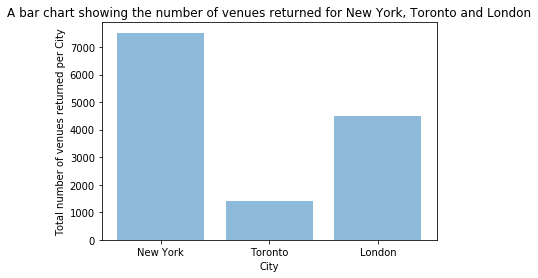

In [367]:
# How many venues returned for each city?
y_labels = ("New York", "Toronto", "London")
y_label_positions = np.arange(len(y_labels))
x_values = [ny_venues_df["Venue"].nunique(), tn_venues_df["Venue"].nunique(), ln_venues_df["Venue"].nunique()]

plt.bar(y_labels, x_values, align = "center", alpha = 0.5)
plt.xlabel("City")
plt.ylabel("Total number of venues returned per City")
plt.title("A bar chart showing the number of venues returned for New York, Toronto and London")

plt.show()

In [368]:
# Ratio of venues received per city compared to the ration of neighbourhoods in each city
sum_neigh = ny_df["Neighbourhood"].nunique() + tn_df["Neighbourhood"].nunique() + ln_df["Neighbourhood"].nunique()
sum_venues = ny_venues_df["Venue"].nunique() + tn_venues_df["Venue"].nunique() + ln_venues_df["Venue"].nunique()

print("Ratio of Neighbourhoods  (NY:TN:LN):",
      round(ny_df["Neighbourhood"].nunique()/sum_neigh,2),":", round(tn_df["Neighbourhood"].nunique()/sum_neigh,2), ":", 
      round(ln_df["Neighbourhood"].nunique()/sum_neigh,2))
print("Ratio of Venues Received (NY:TN:LN):",
      round(ny_venues_df["Venue"].nunique()/sum_venues,2),":", round(tn_venues_df["Venue"].nunique()/sum_venues,2), ":", 
      round(ln_venues_df["Venue"].nunique()/sum_venues,2))

Ratio of Neighbourhoods  (NY:TN:LN): 0.51 : 0.18 : 0.31
Ratio of Venues Received (NY:TN:LN): 0.56 : 0.1 : 0.34


Text(0, 0.5, 'Spread of the number of venues identified per neighbourhood')

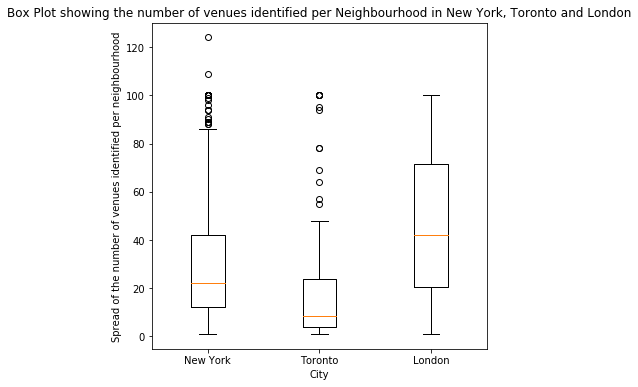

In [374]:
# How may venues per Neighbourhood in each city? 
ny_bp_tmp_1 = ny_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ny_bp_tmp_1.reset_index(inplace = True)

tn_bp_tmp_1 =tn_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
tn_bp_tmp_1.reset_index(inplace = True)

ln_bp_tmp_1 = ln_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ln_bp_tmp_1.reset_index(inplace = True)

data_to_plot_1 = [list(ny_bp_tmp_1["Venue"]), list(tn_bp_tmp_1["Venue"]), list(ln_bp_tmp_1["Venue"])]

fig = plt.figure(1, figsize=(6, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot_1)
ax.set_xticklabels(['New York', 'Toronto', 'London'])
ax.set_title("Box Plot showing the number of venues identified per Neighbourhood in New York, Toronto and London")
ax.set_xlabel("City")
ax.set_ylabel("Spread of the number of venues identified per neighbourhood")

In [494]:
# Filter the dataframes to only include Neighbourhoods where more that 10 venues were identified
ven_per_neigh = 20

ny_filtering_df_1 = ny_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ny_filtering_df_1.rename(columns = {"Venue": "Total Venues Neighbourhood"}, inplace = True)
ny_filtering_df_2 = pd.merge(ny_venues_df, ny_filtering_df_1, on = "Neighbourhood", how = "inner").drop_duplicates()
ny_filtering_df_2_2 = ny_filtering_df_2[ny_filtering_df_2["Total Venues Neighbourhood"] <= 100].reset_index(drop = True)
ny_venues_filt_df = ny_filtering_df_2_2[ny_filtering_df_2_2["Total Venues Neighbourhood"] > ven_per_neigh].reset_index(drop = True)

tn_filtering_df_1 = tn_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
tn_filtering_df_1.rename(columns = {"Venue": "Total Venues Neighbourhood"}, inplace = True)
tn_filtering_df_2 = pd.merge(tn_venues_df, tn_filtering_df_1, on = "Neighbourhood", how = "inner").drop_duplicates()
tn_venues_filt_df = tn_filtering_df_2[tn_filtering_df_2["Total Venues Neighbourhood"] > ven_per_neigh].reset_index(drop = True)

ln_filtering_df_1 = ln_venues_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ln_filtering_df_1.rename(columns = {"Venue": "Total Venues Neighbourhood"}, inplace = True)
ln_filtering_df_2 = pd.merge(ln_venues_df, ln_filtering_df_1, on = "Neighbourhood", how = "inner").drop_duplicates()
ln_venues_filt_df = ln_filtering_df_2[ln_filtering_df_2["Total Venues Neighbourhood"] > ven_per_neigh].reset_index(drop = True)

Text(0, 0.5, 'Spread of the number of venues identified per neighbourhood')

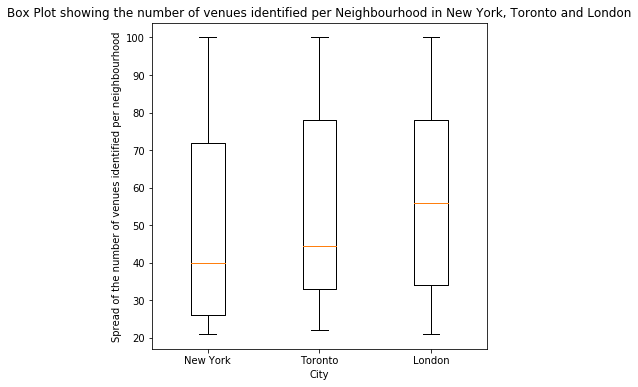

In [495]:
# How may venues per Neighbourhood in each city? 
ny_bp_tmp_1 = ny_venues_filt_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ny_bp_tmp_1.reset_index(inplace = True)

tn_bp_tmp_1 =tn_venues_filt_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
tn_bp_tmp_1.reset_index(inplace = True)

ln_bp_tmp_1 = ln_venues_filt_df[["Neighbourhood", "Venue"]].groupby("Neighbourhood").count()
ln_bp_tmp_1.reset_index(inplace = True)

data_to_plot_2 = [list(ny_bp_tmp_1["Venue"]), list(tn_bp_tmp_1["Venue"]), list(ln_bp_tmp_1["Venue"])]

fig = plt.figure(1, figsize=(6, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot_2)
ax.set_xticklabels(['New York', 'Toronto', 'London'])
ax.set_title("Box Plot showing the number of venues identified per Neighbourhood in New York, Toronto and London")
ax.set_xlabel("City")
ax.set_ylabel("Spread of the number of venues identified per neighbourhood")

### Step 12 - Prepare the data for k-means clustering

In [496]:
# Merge the data from all of the cities into one dataframe, add a column to label which city the data has come from
ny_venues_df["City"] = "New York"
tn_venues_df["City"] = "Toronto"
ln_venues_df["City"] = "London"
all_venues_df = ny_venues_filt_df.append([tn_venues_filt_df, ln_venues_filt_df])

# one hot encoding
all_venues_onehot_df = pd.get_dummies(all_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add back in the neighbourhood
all_venues_onehot_df["Neighbourhood"] = all_venues_df["Neighbourhood"]

# group the onehot encoding
all_venues_grouped_df = all_venues_onehot_df.groupby("Neighbourhood").mean().reset_index()

In [491]:
# Define a function to return the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [504]:
# Define the number of top veneus
num_top_venues = 10
# Define indicator suffixes
indicators = ['st', 'nd', 'rd']

# Create a list containing column headers
column_headers = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        column_headers.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        column_headers.append('{}th Most Common Venue'.format(ind+1))

# Create a new datafram containing the top 10 most common venues for each neighbourhood
all_venues_sorted = pd.DataFrame(columns=column_headers)
all_venues_sorted['Neighbourhood'] = all_venues_grouped_df['Neighbourhood']
# all_venues_sorted['Borough'] = all_venues_grouped_df['Borough']
# all_venues_sorted['City'] = all_venues_grouped_df['City']
        
for ind in np.arange(all_venues_grouped_df.shape[0]):
    all_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_venues_grouped_df.iloc[ind, :], num_top_venues)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Spa,Department Store,Supermarket,Bus Station,Martial Arts Dojo,Grocery Store,Food,Gas Station
1,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Bagel Shop,Cosmetics Shop,Athletics & Sports,Food Truck,Supermarket,Middle Eastern Restaurant,Outdoors & Recreation
2,Astoria,Middle Eastern Restaurant,Bar,Hookah Bar,Mediterranean Restaurant,Indian Restaurant,Deli / Bodega,Seafood Restaurant,Greek Restaurant,Bakery,Café
3,Bath Beach,Chinese Restaurant,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Gas Station,Italian Restaurant,Donut Shop,Bakery,Bank
4,Battery Park City,Park,Hotel,Memorial Site,Gym,Shopping Mall,Gourmet Shop,Beer Garden,Coffee Shop,Mexican Restaurant,Food Court


### Step 13 - Identify the optimum K value for K means clustering

In [498]:
venues_clustering = all_venues_grouped_df.drop('Neighbourhood', 1)
k_values = []
distortion = []
for k in range(1,20):
    kmean_clustering = KMeans(n_clusters = k, random_state = 0).fit(venues_clustering)
    print(k, kmean_clustering.inertia_)
    k_values.append(k)
    distortion.append(kmean_clustering.inertia_)

1 10.802557561696311
2 9.824462485898456
3 9.248616642880346
4 8.997054643376492
5 8.82811083325853
6 8.652473093760717
7 8.501952688830109
8 8.370738411326865
9 8.320323017011983
10 8.235507589210592
11 8.086291613252415
12 8.064116144371393
13 7.97285884012334
14 7.848947723629245
15 7.787795568797531
16 7.697654691947298
17 7.668996067441098
18 7.597480757023736
19 7.511474348511988


Text(0.5, 1.0, 'A graph to show the change in distortion fo increaing values of k')

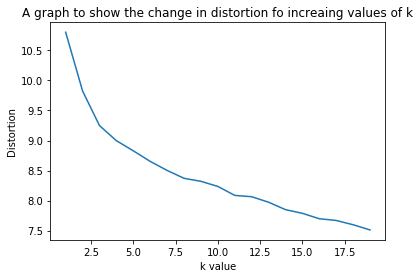

In [499]:
plt.plot(k_values, distortion)
plt.xlabel("k value")
plt.ylabel("Distortion")
plt.title("A graph to show the change in distortion fo increaing values of k")

### Step 14 - Conduct K means clustering with k = 4

In [554]:
kmean_clustering_venues = KMeans(n_clusters = 4, random_state = 0).fit(venues_clustering)
all_venues_sorted.insert(0, 'Cluster Labels', kmean_clustering_venues.labels_)

In [574]:
# Obtain a list of all Cities, Boroughs and Neighbourhoods
cbn_df = all_venues_df[["City", "Borough", "Neighbourhood", "Neighborhood Latitude", "Neighborhood Longitude"]].drop_duplicates()
cbn_df.reset_index(inplace = True)

#Join Back onto list 
results_df = pd.merge(all_venues_sorted, cbn_df, on = "Neighbourhood", how = "inner")

results_df.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,index,City,Borough,Neighborhood Latitude,Neighborhood Longitude
0,2,Allerton,Pizza Place,Chinese Restaurant,Spa,Department Store,Supermarket,Bus Station,Martial Arts Dojo,Grocery Store,Food,Gas Station,7871,New York,Bronx,40.865788,-73.859319
1,3,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Bagel Shop,Cosmetics Shop,Athletics & Sports,Food Truck,Supermarket,Middle Eastern Restaurant,Outdoors & Recreation,6508,New York,Staten Island,40.596313,-74.067124
2,3,Astoria,Middle Eastern Restaurant,Bar,Hookah Bar,Mediterranean Restaurant,Indian Restaurant,Deli / Bodega,Seafood Restaurant,Greek Restaurant,Bakery,Café,4800,New York,Queens,40.768509,-73.915654
3,2,Bath Beach,Chinese Restaurant,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Gas Station,Italian Restaurant,Donut Shop,Bakery,Bank,1933,New York,Brooklyn,40.599519,-73.998752
4,0,Battery Park City,Park,Hotel,Memorial Site,Gym,Shopping Mall,Gourmet Shop,Beer Garden,Coffee Shop,Mexican Restaurant,Food Court,4640,New York,Manhattan,40.711932,-74.016869


### Step 15 - Create a map of New York, Toronto and London showing all the cluster associated with each neighbourhood in different colours

In [557]:
# Creat an array of colors required for plotting each of the clusters in different colours on the map
col_x = results_df["Cluster Labels"].unique()
col_y = [i + col_x + (i*col_x)**2 for i in range(results_df["Cluster Labels"].nunique())]
colors_array = cm.rainbow(np.linspace(0, 1, len(col_y)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [567]:
# NEW YORK
#Create a datafram only containing the results for New York
ny_results_for_map = results_df[results_df["City"]  == "New York"]

# Create an instance of the geolocator to obtain coordinates for New York
ny_geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode("New York City")

# Create a instance of the folium map, centred around the coordinates for New York
ny_results_map = folium.Map(location=[ny_location.latitude, ny_location.longitude], zoom_start=10)

# Add the neighbourhoods onto the map of New York
for lat, lng, neigh, borough in zip(ny_results_for_map['Neighborhood Latitude'], ny_results_for_map['Neighborhood Longitude'], 
                                    ny_results_for_map['Neighbourhood'], ny_results_for_map["Cluster Labels"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[borough-1],
        fill=True,
        fill_color=rainbow[borough-1],
        fill_opacity=0.7).add_to(ny_results_map)  
    
ny_results_map

In [559]:
# TORONTO
#Create a datafram only containing the results for Toronto
tn_results_for_map = results_df[results_df["City"]  == "Toronto"]

# Create an instance of the geolocator to obtain coordinates for Toronto
tn_geolocator = Nominatim(user_agent="tn_explorer")
tn_location = geolocator.geocode("Toronto")

# Create a instance of the folium map, centred around the coordinates for Toronto
tn_results_map = folium.Map(location=[tn_location.latitude, tn_location.longitude], zoom_start=10)

# Add the neighbourhoods onto the map of New York
for lat, lng, neigh, borough in zip(tn_results_for_map['Neighborhood Latitude'], tn_results_for_map['Neighborhood Longitude'], 
                                    tn_results_for_map['Neighbourhood'], tn_results_for_map["Cluster Labels"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[borough-1],
        fill=True,
        fill_color=rainbow[borough-1],
        fill_opacity=0.7).add_to(tn_results_map)  
    
tn_results_map

In [560]:
# LONDON
#Create a datafram only containing the results for London
ln_results_for_map = results_df[results_df["City"]  == "London"]

# Create an instance of the geolocator to obtain coordinates for London
ln_geolocator = Nominatim(user_agent="ln_explorer")
ln_location = geolocator.geocode("London")

# Create a instance of the folium map, centred around the coordinates for London
ln_results_map = folium.Map(location=[ln_location.latitude, ln_location.longitude], zoom_start=10)

# Add the neighbourhoods onto the map of New York
for lat, lng, neigh, borough in zip(ln_results_for_map['Neighborhood Latitude'], ln_results_for_map['Neighborhood Longitude'], 
                                    ln_results_for_map['Neighbourhood'], ln_results_for_map["Cluster Labels"]):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[borough-1],
        fill=True,
        fill_color=rainbow[borough-1],
        fill_opacity=0.7).add_to(ln_results_map)  
    
ln_results_map

In [616]:
# print("The clients current shops are located in the "
tmp_1 = results_df[results_df["Neighbourhood"].isin(["Greenwich Village", "Soho", "Little Italy"])]

print("The customers current fruit shops are loacted in the following neighbourhoods with the following clusters\n"
      , tmp_1[["Neighbourhood", "Cluster Labels"]].reset_index(drop = True))


pd.DataFrame(results_df.groupby(["City", "Cluster Labels"]).size())

The customers current fruit shops are loacted in the following neighbourhoods with the following clusters
        Neighbourhood  Cluster Labels
0  Greenwich Village               3
1       Little Italy               3
2               Soho               3


0
City     Cluster Labels    
London   0               43
         1               85
         3                6
New York 0                8
         2               71
         3               81
Toronto  0               15
         1                3
         3               12